# **IAA - PRÀCTICA: MAIN**

### **Instal·lar llibreries necessàries**

In [ ]:
%pip install -r ../assets/requirements.txt 

### **Importar llibreries**

In [2]:
def import_dependencies():
	global pd, np, plt, sns, skl

	import pandas as pd
	import numpy as np
	import matplotlib.pyplot as plt
	import seaborn as sns
	import sklearn as skl

import_dependencies()

### **Llegir les dades (Cirrhosis Dataset)**

In [3]:
def load_dataset(save_to_csv: bool = True):
	from ucimlrepo import fetch_ucirepo 
	
	# Fetch dataset
	cirrhosis_patient_survival_prediction = fetch_ucirepo(id=878)

	data = pd.DataFrame(cirrhosis_patient_survival_prediction.data.original)

	if save_to_csv:
		# Guardem el dataset per poder-lo visualitzar sencer
		data.to_csv('../assets/data/raw_cirrhosis.csv', index=False)

	return data

data = load_dataset(save_to_csv=True)

### **Informació del dataset inicial**

In [ ]:
data.shape

In [ ]:
data.head(-10)

In [ ]:
data.info()

### **Preprocessing inicial**

In [4]:
def initial_preprocessing(data: pd.DataFrame, save_to_csv: bool = True):
	"""
	Reemplaça els valors 'NaNN' per NaN, assigna els tipus de dades correctes a cada columna i renombra les classes d'algunes variables per una millor comprensió.
	"""
	data = data.copy()

	# Reemplaçar l'string 'NaNN' per NaN
	data = data.replace(to_replace=['NaNN', '', pd.NA], value=np.nan)

	# Eliminem variables que no aporten informació
	data = data.drop(columns=['ID'])

	# Assignem els tipus de dades correctes a cada columna
	int64_variables = ['N_Days', 'Age', 'Cholesterol', 'Copper', 'Tryglicerides', 'Platelets']
	float64_variables = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT', 'Prothrombin']
	category_variables = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']
	y_n_variables = ['Ascites', 'Hepatomegaly', 'Spiders']

	data[int64_variables] = data[int64_variables].astype('Int64')
	data[float64_variables] = data[float64_variables].astype('float64')
	data[category_variables] = data[category_variables].astype('category')

	global original_column_types

	original_column_types = {col: str(data[col].dtype) for col in data.columns} # Guardem els tipus de dades de cada columna

	# Renombrem les classes d'algunes variables per una millor comprensió
	data['Status'] = data['Status'].replace({'D': 'Dead', 'C': 'Alive', 'CL': 'LiverTransplant'})
	data[y_n_variables] = data[y_n_variables].replace({'Y': 1, 'N': 0})
	data['Edema'] = data['Edema'].replace({'N': 'NoEdema', 'S': 'EdemaResolved', 'Y': 'EdemaPersistent'})
	data['Drug'] = data['Drug'].replace({'D-penicillamine': 1, 'Placebo': 0})

	# Comprovem que les variables contenen les classes correctes
	assert set(data['Status'].dropna().unique().tolist()) == {'Dead', 'Alive', 'LiverTransplant'}
	assert set(data['Drug'].dropna().unique().tolist()) == {1, 0}
	for col in y_n_variables:
		assert set(data[col].dropna().unique().tolist()) == {1, 0}
	assert set(data['Edema'].dropna().unique().tolist()) == {'NoEdema', 'EdemaResolved', 'EdemaPersistent'}

	global original_categorical_categories
	original_categorical_categories = {col: data[col].unique().tolist() for col in data.select_dtypes(include='category').columns} # Guardem les categories originals de les variables categòriques

	if save_to_csv:
		# Guardem el dataset
		data.to_csv('../assets/data/initial_preprocessing_cirrhosis.csv', index=False)

	return data

data = initial_preprocessing(data=data, save_to_csv=True)

In [ ]:
data.head(-10)

In [ ]:
data.info()

### **Anàlisis inicial de les variables**

In [ ]:
data.head(-10)

In [ ]:
data.isna().sum().sort_values(ascending=False)

In [ ]:
# Estudi de les variables numèriques
data.describe()

In [ ]:
# Estadístiques de les variables categòriques
data.describe(include='category')

In [ ]:
def numerical_vars_histograms(data: pd.DataFrame):
    # Visualització de les distribucions de les variables numèriques en una sola figura
    numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

    num_rows = int(np.ceil(len(numerical_columns) / 2))

    fig = plt.figure(figsize=(10, num_rows * 4))

    for i, col in enumerate(numerical_columns):
        ax = fig.add_subplot(num_rows, 2, i + 1)
        
        sns.histplot(data[col], edgecolor="k", linewidth=1.5, kde=True)
        
        plt.xticks(rotation=45, ha='right')
        
        ax.set_title(f'Distribució de la variable numèrica {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Freqüència')

    plt.tight_layout()
    plt.savefig('../assets/plots/numerical_vars_histograms.png')
    plt.show()

numerical_vars_histograms(data=data)

In [ ]:
def categorical_vars_countplots(data: pd.DataFrame):
    """
    Visualització de les distribucions de les variables categòriques en una sola figura.
    """
    # Visualització de les distribucions de les variables categòriques en una sola figura
    categorical_columns = data.select_dtypes(include=['category']).columns
    num_rows = int(np.ceil(len(categorical_columns) / 2))

    fig = plt.figure(figsize=(10, num_rows * 4))

    for i, col in enumerate(categorical_columns):
        ax = fig.add_subplot(num_rows, 2, i + 1)
        
        sns.countplot(data=data, x=col, ax=ax, hue=col, legend=False)
        
        plt.xticks(rotation=45, ha='right')
        
        ax.set_title(f'Distribució de la variable categòrica {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Quantitat')

    plt.tight_layout()
    plt.savefig('../assets/plots/categorical_vars_countplots.png')
    plt.show()


categorical_vars_countplots(data=data)

### **Tractament d'outliers**

In [ ]:
def compare_iqr_factors(data: pd.DataFrame, factors: list = [1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]):
	"""
	Compara diferents factors que multipliquen al IQR per a determinar els outliers i realitza un gràfic evolutiu per comparar-los.
	"""
	data = data.copy()

	numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

	plt.figure(figsize=(10, 6))

	# Dictionary to store outlier percentages for each factor and column
	outlier_percentages = {col: [] for col in numerical_columns}
	total_percentages = [set() for _ in range(len(factors))]

	for col in numerical_columns:
		Q1 = data[col].quantile(0.25)
		Q3 = data[col].quantile(0.75)
		IQR = Q3 - Q1

		for f_id, factor in enumerate(factors):
			outliers_mask = ((data[col] < (Q1 - factor * IQR)) | (data[col] > (Q3 + factor * IQR)))
			total_percentages[f_id].update(data.index[outliers_mask])
			outliers_percentage = np.mean(outliers_mask) * 100
			outlier_percentages[col].append(outliers_percentage)

	total_percentages = [(len(outliers) / len(data)) * 100 for outliers in total_percentages]
			
	# Plotting the results
	for col, percentages in outlier_percentages.items():
		plt.plot(factors, percentages, label=col)
	plt.plot(factors, total_percentages, label='Total', linestyle='--', color='black')

	plt.xlabel('Factor multiplicatiu del IQR')
	plt.ylabel('Percentage d\'outliers (%)')
	plt.title('Percentatge d\'outliers de cada variable numèrica per a diferents factors multiplicatius del IQR')
	plt.xticks(factors)
	
	plt.legend()
	plt.grid(True)
	plt.show()

compare_iqr_factors(data=data, factors=[1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5])

In [5]:
def delete_outliers(data: pd.DataFrame, factor: float = 3, plots: bool = True, save_to_csv: bool = True, hide_messages: bool = False):
    """
    Funció que detecta, visualitza i elimina els outliers d'un dataset. El factor multiplica el IQR per a determinar quins valors són outliers.
    """
    # Detecció, visualització i eliminació d'outliers
    data = data.copy()

    numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

    outliers_indices = []

    for col in numerical_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        outliers_mask = ((data[col] < lower_bound) | (data[col] > upper_bound))
        outliers = data[col][outliers_mask]
        non_outliers = data[col][~outliers_mask]

        outliers_indices.extend(data[col][outliers_mask].index.tolist())
        
        if plots:
            fig, axes = plt.subplots(2, 2, figsize=(8, 6))

            # Boxplot amb els outliers originals
            sns.boxplot(ax=axes[0, 0], y=data[col], orient='v')
            axes[0, 0].scatter(x=[0]*len(outliers), y=outliers, color='red', marker='o')
            axes[0, 0].set_title(f'Boxplot de {col} amb outliers ({factor}x IQR)')

            # Histograma amb línia vertical als límits dels outliers
            sns.histplot(ax=axes[0, 1], data=data, x=col, kde=True)
            if (data[col] < lower_bound).any():
                axes[0, 1].axvline(x=lower_bound, color='red', linestyle='dashed')
            if (data[col] > upper_bound).any():
                axes[0, 1].axvline(x=upper_bound, color='red', linestyle='dashed')
            axes[0, 1].set_title(f'Histograma de {col}')
            axes[0, 1].set_xlabel(col)
            axes[0, 1].set_ylabel('Freqüència')

            # Boxplot sense els outliers
            sns.boxplot(ax=axes[1, 0], y=non_outliers, orient='v')
            axes[1, 0].set_title(f'Boxplot de {col} sense outliers')

            # Histograma sense els outliers
            sns.histplot(ax=axes[1, 1], data=data[~outliers_mask], x=col, kde=True)
            axes[1, 1].set_title(f'Histograma de {col} sense outliers')

            percent_outliers = len(outliers) / data.shape[0] * 100
            fig.text(x=0.5, y=0, s=f'Outliers de {col} ({factor}x IQR): {len(outliers)} ({percent_outliers:.2f}%)', 
                    ha='center', va='center')

            plt.tight_layout()
            # Guardem la figura evitant que es talli el text de la part inferior
            plt.savefig(f'../assets/plots/outliers_{col}.png', bbox_inches='tight')
            plt.show()


    unique_outliers = len(set(outliers_indices))

    if not hide_messages:
        print(f"Datset amb outliers: {data.shape[0]} files i {data.shape[1]} columnes.")
        print(f"Nombre total d'outliers únics eliminats: {unique_outliers} ({unique_outliers / data.shape[0] * 100:.2f}% de tot el dataset).")

    # Eliminació d'outliers
    data = data.drop(list(set(outliers_indices)))

    if not hide_messages:
        print(f"Dataset sense outliers: {data.shape[0]} files i {data.shape[1]} columnes.")

    if save_to_csv:
        # Guardem el dataset
        data.to_csv('../assets/data/no_outliers_cirrhosis.csv', index=False)

    return data

data = delete_outliers(data=data, factor=3, plots=False, save_to_csv=True)

Datset amb outliers: 418 files i 19 columnes.
Nombre total d'outliers únics eliminats: 70 (16.75% de tot el dataset).
Dataset sense outliers: 348 files i 19 columnes.


### **Funció per eliminar mostres amb masses missings**

In [6]:
def delete_last_rows(data: pd.DataFrame, save_to_csv: bool = True):
	"""
	Elimina les últimes files del dataset (les que contenen 9 NaNs).
	"""
	data = data.copy()

	# Eliminem les últimes files del dataset (les que contenen 9 NaNs)
	data = data.drop(data[data.isna().sum(axis=1) == 9].index)

	if save_to_csv:
		# Guardem el dataset
		data.to_csv('../assets/data/last_rows_deleted_cirrhosis.csv', index=False)

	return data

#data = delete_last_rows(data=data, save_to_csv=True)

### **Recodificació de variables categòriques**

In [7]:
def encode_variables(data: pd.DataFrame, save_to_csv: bool = True):
    """
    Codifica les variables categòruqes mitjançant OrdinalEncoder.
    """
    assert not data.isna().any().any(), "El dataset no pot contenir valors NaN per a poder codificar les variables categòriques."

    data = data.copy()

    categorical_columns = data.select_dtypes(include='category').columns
    numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

    from sklearn.preprocessing import OrdinalEncoder

    oe = OrdinalEncoder()

    # Ajustar i transformar el dataset
    cat_cols_encoded = oe.fit_transform(data[categorical_columns])

    data_encoded = np.concatenate((cat_cols_encoded, data[numerical_columns]), axis=1)
    
    # Actualizar el dataset con las columnas codificadas
    data_encoded = pd.DataFrame(data_encoded, columns=categorical_columns.tolist() + numerical_columns.tolist())

    if save_to_csv:
        data.to_csv('../assets/data/encoded_cirrhosis.csv', index=False)

    return data_encoded

#data = encode_variables(data=data, save_to_csv=True)

### **Partició del dataset en train/test**

In [8]:
def split_dataset(data: pd.DataFrame, test_size: float = 0.15, stratify: bool = True, random_state: int = 42, hide_messages: bool = False):
	"""
	Particiona el dataset en conjunts de entrenament i prova.
	"""	
	data = data.copy()

	from sklearn.model_selection import train_test_split

	# Particionem el dataset en conjunts de entrenament i prova
	if stratify:
		train, test = train_test_split(data, test_size=test_size, random_state=random_state, stratify=data['Status'])
	else:
		train, test = train_test_split(data, test_size=test_size, random_state=random_state)

	# 'Status' es la variable target
	X_train = train.drop(columns=['Status'])
	y_train = train['Status']
	X_test = test.drop(columns=['Status'])
	y_test = test['Status']

	# Passem a dataframe o series
	X_train = pd.DataFrame(X_train)
	X_test = pd.DataFrame(X_test)

	y_train = pd.Series(y_train)
	y_test = pd.Series(y_test)

	if not hide_messages:
		print(f"Train shape: {train.shape}")
		print(f"Test shape: {test.shape}")

	return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_dataset(data=data, test_size=0.15, random_state=42, stratify=True)

Train shape: (295, 19)
Test shape: (53, 19)


### **Escalar variables numèriques**

In [9]:
def scale_variables(data: pd.DataFrame, scaler: str = 'minmax', save_to_csv: bool = True):
	assert scaler in ['standard', 'minmax'], "El paràmetre 'scaler' ha de ser 'standard' o 'minmax'."
	"""
	Escala les variables numèriques.
	"""
	data = data.copy()

	from sklearn.preprocessing import StandardScaler, MinMaxScaler

	numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns

	sc = StandardScaler() if scaler == 'standard' else MinMaxScaler()

	data[numerical_columns] = sc.fit_transform(data[numerical_columns])

	if save_to_csv:
		# Guardem el dataset
		data.to_csv('../assets/data/scaled_cirrhosis.csv', index=False)

	return data

X_train = scale_variables(data=X_train, scaler='minmax', save_to_csv=True)
X_test = scale_variables(data=X_test, scaler='minmax', save_to_csv=True)

### **Imputar els valors faltants (Missings)**

In [10]:
def find_best_imputer(
                X_train: pd.DataFrame, \
                folds_cross_val: int = 5, \
                random_state: int = 42, \
                print_scores: bool = True, \
                name_num_metric: str = 'r2', \
                name_cat_metric: str = 'accuracy'):
    """
    Prova diferents imputadors, imprimeix els seus resultats i retorna el millor.
    """
    from sklearn.model_selection import KFold
    from sklearn.metrics import r2_score, accuracy_score, f1_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
    from sklearn.impute import KNNImputer, SimpleImputer
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LinearRegression
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

    X_train = X_train.copy()

    assert folds_cross_val > 1, "El paràmetre 'n_splits' ha de ser major que 1."
    
    # Definir mètriques
    f1_micro = lambda y_true, y_pred: f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted', zero_division=0)
    precision_micro = lambda y_true, y_pred: precision_score(y_true, y_pred, average='micro', zero_division=0)
    precision_macro = lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_weighted = lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_micro = lambda y_true, y_pred: recall_score(y_true, y_pred, average='micro', zero_division=0)
    recall_macro = lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_weighted = lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted', zero_division=0)

    # Mapeig de les mètriques
    metric_functions = {
        'numerical': {
            'r2': r2_score, \
            'mse': mean_squared_error, \
            'mae': mean_absolute_error, \
            'mape': mean_absolute_percentage_error
        },
        'categorical': {
            'accuracy': accuracy_score, \
            'f1-micro': f1_micro, \
            'f1-macro': f1_macro, \
            'f1-weighted': f1_weighted, \
            'precision-micro': precision_micro, \
            'precision-macro': precision_macro, \
            'precision-weighted': precision_weighted, \
            'recall-micro': recall_micro, \
            'recall-macro': recall_macro, \
            'recall-weighted': recall_weighted
        }                
    }

    assert name_num_metric in metric_functions['numerical'].keys(), f"El paràmetre 'name_num_metric' ha de ser una de les següents mètriques: {metric_functions['numerical'].keys()}. Ara mateix és: {name_num_metric}"
    assert name_cat_metric in metric_functions['categorical'].keys(), f"El paràmetre 'name_cat_metric' ha de ser una de les següents mètriques: {metric_functions['categorical'].keys()}"

    num_metric = metric_functions['numerical'][name_num_metric]
    cat_metric = metric_functions['categorical'][name_cat_metric]

    # Definir les particions per a la validació creuada
    kf = KFold(n_splits=folds_cross_val, random_state=random_state, shuffle=True)
    
    # Inicialización de imputadores
    imputers = {
        'numerical': 
            {
            'KNNImputer-1': KNNImputer(n_neighbors=1),
            'KNNImputer-2': KNNImputer(n_neighbors=2),
            'KNNImputer-3': KNNImputer(n_neighbors=3),
            'KNNImputer-5': KNNImputer(n_neighbors=5),
            'KNNImputer-10': KNNImputer(n_neighbors=10),
            'KNNImputer-15': KNNImputer(n_neighbors=15),
            'KNNImputer-20': KNNImputer(n_neighbors=20),
            'KNNImputer-25': KNNImputer(n_neighbors=25),
            'KNNImputer-50': KNNImputer(n_neighbors=50),
            'SimpleImputer-mean': SimpleImputer(strategy='mean'),
            'IterativeImputer-lr': IterativeImputer(estimator=LinearRegression(fit_intercept=True), random_state=random_state),
        },

        'categorical': 
            {
            'KNeighborsClassifier-1': KNeighborsClassifier(n_neighbors=1),
            'KNeighborsClassifier-2': KNeighborsClassifier(n_neighbors=2),
            'KNeighborsClassifier-3': KNeighborsClassifier(n_neighbors=3),
            'KNeighborsClassifier-5': KNeighborsClassifier(n_neighbors=5),
            'KNeighborsClassifier-10': KNeighborsClassifier(n_neighbors=10),
            'KNeighborsClassifier-15': KNeighborsClassifier(n_neighbors=15),
            'KNeighborsClassifier-20': KNeighborsClassifier(n_neighbors=20),
            'KNeighborsClassifier-25': KNeighborsClassifier(n_neighbors=25),
            'KNeighborsClassifier-50': KNeighborsClassifier(n_neighbors=50),
            'DecisionTreeClassifier-gini': DecisionTreeClassifier(criterion='gini', random_state=random_state),
            'DecisionTreeClassifier-entropy': DecisionTreeClassifier(criterion='entropy', random_state=random_state), 
            'RandomForestClassifier-gini': RandomForestClassifier(criterion='gini', random_state=random_state),
            'RandomForestClassifier-entropy': RandomForestClassifier(criterion='entropy', random_state=random_state),
        }
    }

    # Inicialització dels resultats
    scores = {'numerical': {name_num_imputer: [] for name_num_imputer in imputers['numerical'].keys()},
              'categorical': {name_cat_imputer: [] for name_cat_imputer in imputers['categorical'].keys()}}
    
    # Treiem les files amb NaNs
    X_train_complete = X_train.dropna()

    numerical_columns = X_train_complete.select_dtypes(include=['Int64', 'float64']).columns
    categorical_columns = X_train_complete.select_dtypes(include=['category']).columns

    for train_index, test_index in kf.split(X_train_complete):
        X_train_fold, X_test_fold = X_train_complete.iloc[train_index], X_train_complete.iloc[test_index]

        # Imputació i evaluació per a numèriques
        for name, imputer in imputers['numerical'].items():
            # Introdir artificalment NaNs
            X_test_fold_num_with_nan = X_test_fold.copy()
            for index in X_test_fold.index:
                # Seleccionar aleatoriament una columna numèrica i una categòrica
                np.random.seed(random_state)
                num_col = np.random.choice(numerical_columns)
                X_test_fold_num_with_nan.loc[index, num_col] = np.nan # Només NaNs en les columnes numèriques

            imputer.fit(X_train_fold[numerical_columns])
            X_test_num_imputed = imputer.transform(X_test_fold_num_with_nan[numerical_columns])
            X_test_num_imputed = pd.DataFrame(X_test_num_imputed, columns=numerical_columns, index=X_test_fold_num_with_nan.index)

            num_cols_scores = []
            for col in numerical_columns:
                if X_test_fold_num_with_nan[col].isna().any():
                    # Només evaluar les columnes amb NaNs
                    true_values = X_test_fold[col]
                    imputed_values = X_test_num_imputed[col]
                    score = num_metric(true_values, imputed_values)
                    num_cols_scores.append(score)
                
            scores['numerical'][name].append(np.mean(num_cols_scores))
                
        # Imputació i evaluació per a categòriques
        for name, imputer in imputers['categorical'].items():
            # Introdir artificalment NaNs
            X_test_fold_cat_with_nan = X_test_fold.copy()
            for index in X_test_fold.index:
                # Seleccionar aleatoriament una columna numèrica i una categòrica
                np.random.seed(random_state)
                cat_col = np.random.choice(categorical_columns)
                X_test_fold_cat_with_nan.loc[index, cat_col] = np.nan # Només NaNs en les columnes categòriques

            cat_cols_scores = []
            for col in categorical_columns:
                cat_metric = metric_functions['categorical'][name_cat_metric]
                imputer.fit(X_train_fold[numerical_columns], X_train_fold[col])
                X_test_cat_col_imputed = imputer.predict(X_test_fold_cat_with_nan[numerical_columns])
                X_test_cat_col_imputed = pd.Series(X_test_cat_col_imputed, index=X_test_fold_cat_with_nan.index)

                true_values = X_test_fold[col]
                predicted_values = X_test_cat_col_imputed
                score = cat_metric(true_values, predicted_values)
                cat_cols_scores.append(score)

            scores['categorical'][name].append(np.mean(cat_cols_scores))

    # Calcular la mitjana dels resultats
    average_scores = {
        'numerical': {name: np.mean(scores_val) for name, scores_val in scores['numerical'].items()},
        'categorical': {name: np.mean(scores_val) for name, scores_val in scores['categorical'].items()}
    }
    
    # Guardar el millor imputador numèric
    best_num_imputer_name = 'None'
    best_num_imputer_score = float('-inf') if name_num_metric not in {'mse', 'mae', 'mape'} else float('inf')
    num_condition = lambda x, y: x > y if name_num_metric not in {'mse', 'mae', 'mape'} else x < y # Si la mètrica és mse, mae o mape el millor imputador és el que tingui el valor més petit
    for name_num_imputer, score_num_imputer in average_scores['numerical'].items():
        if num_condition(score_num_imputer, best_num_imputer_score):
            best_num_imputer_score = score_num_imputer
            best_num_imputer_name = name_num_imputer

    # Guardar el millor imputador categòric
    best_cat_imputer_name = 'None'
    best_cat_imputer_score = float('-inf')
    for name_cat_imputer, score_cat_imputer in average_scores['categorical'].items():
        if score_cat_imputer > best_cat_imputer_score:
            best_cat_imputer_score = score_cat_imputer
            best_cat_imputer_name = name_cat_imputer

    # Mostrar resultats
    if print_scores:
        for name_num_imputer, score_num_imputer in average_scores['numerical'].items():
            print(f"NUMERICAL IMPUTER [{name_num_imputer}] --> {score_num_imputer} (\'{name_num_metric}\' score)")

        for name_cat_imputer, score_cat_imputer in average_scores['categorical'].items():
            print(f"CATEGORICAL IMPUTER [{name_cat_imputer}] --> {score_cat_imputer} (\'{name_cat_metric}\' score)")
        
        print(f"\nBEST NUMERICAL IMPUTER: {best_num_imputer_name} --> {best_num_imputer_score} (\'{name_num_metric}\' score)")
        print(f"BEST CATEGORICAL IMPUTER: {best_cat_imputer_name} --> {best_cat_imputer_score} (\'{name_cat_metric}\' score)")

        if name_num_metric not in {'mse', 'mae', 'mape'}:
            print(f"BEST COMBINED IMPUTER: {best_num_imputer_name} (num) + {best_cat_imputer_name} (cat) --> {np.mean([best_num_imputer_score, best_cat_imputer_score])} (combined \'{name_num_metric}\' & \'{name_cat_metric}\' scores)")
    
    # Retornar els millors imputadors i les seves puntuacions
    return {'numerical': {'name': best_num_imputer_name, 'imputer': imputers['numerical'][best_num_imputer_name], 'score': best_num_imputer_score},
        'categorical': {'name': best_cat_imputer_name, 'imputer': imputers['categorical'][best_cat_imputer_name], 'score': best_cat_imputer_score},
        'combined': {'name': f"{best_num_imputer_name} (num) + {best_cat_imputer_name} (cat)", 'score': np.mean([best_num_imputer_score, best_cat_imputer_score])}}

#best_imputers = find_best_imputer(X_train=train, n_splits=5, random_state=42, print_scores=True, name_num_metric='r2', name_cat_metric='accuracy')

In [11]:
def impute_data(data: pd.DataFrame, \
				X_train: pd.DataFrame, \
				numerical_imputer = 'best', \
				categorical_imputer = 'best', \
				save_to_csv: bool = True, \
				random_state: int = 42, \
				folds_cross_val: int = 5, \
				num_metric = 'r2', \
				cat_metric = 'f1-weighted', \
				hide_messages: bool = False):
	"""
	Imputa els valors NaN del dataset.
	"""
	from sklearn.impute import KNNImputer, SimpleImputer
	from sklearn.neighbors import KNeighborsClassifier
	from sklearn.tree import DecisionTreeClassifier
	from sklearn.ensemble import RandomForestClassifier
	from sklearn.linear_model import LinearRegression
	from sklearn.experimental import enable_iterative_imputer
	from sklearn.impute import IterativeImputer
	
	imputers = {
        'numerical': 
            {
            'KNNImputer-1': KNNImputer(n_neighbors=1),
            'KNNImputer-2': KNNImputer(n_neighbors=2),
            'KNNImputer-3': KNNImputer(n_neighbors=3),
            'KNNImputer-5': KNNImputer(n_neighbors=5),
            'KNNImputer-10': KNNImputer(n_neighbors=10),
            'KNNImputer-15': KNNImputer(n_neighbors=15),
            'KNNImputer-20': KNNImputer(n_neighbors=20),
            'KNNImputer-25': KNNImputer(n_neighbors=25),
            'KNNImputer-50': KNNImputer(n_neighbors=50),
            'SimpleImputer-mean': SimpleImputer(strategy='mean'),
            'IterativeImputer-lr': IterativeImputer(estimator=LinearRegression(fit_intercept=True), random_state=random_state),
        },

        'categorical': 
            {
            'KNeighborsClassifier-1': KNeighborsClassifier(n_neighbors=1),
            'KNeighborsClassifier-2': KNeighborsClassifier(n_neighbors=2),
            'KNeighborsClassifier-3': KNeighborsClassifier(n_neighbors=3),
            'KNeighborsClassifier-5': KNeighborsClassifier(n_neighbors=5),
            'KNeighborsClassifier-10': KNeighborsClassifier(n_neighbors=10),
            'KNeighborsClassifier-15': KNeighborsClassifier(n_neighbors=15),
            'KNeighborsClassifier-20': KNeighborsClassifier(n_neighbors=20),
            'KNeighborsClassifier-25': KNeighborsClassifier(n_neighbors=25),
            'KNeighborsClassifier-50': KNeighborsClassifier(n_neighbors=50),
            'DecisionTreeClassifier-gini': DecisionTreeClassifier(criterion='gini', random_state=random_state),
            'DecisionTreeClassifier-entropy': DecisionTreeClassifier(criterion='entropy', random_state=random_state), 
            'RandomForestClassifier-gini': RandomForestClassifier(criterion='gini', random_state=random_state),
            'RandomForestClassifier-entropy': RandomForestClassifier(criterion='entropy', random_state=random_state),
        }
    }

	possible_numerical_imputers = imputers['numerical'].keys()
	assert numerical_imputer in possible_numerical_imputers or numerical_imputer == 'best', f"numerical_imputer ha de ser un dels següents valors: {possible_numerical_imputers} (o 'best' per trobar el millor)"
	possible_categorical_imputers = imputers['categorical'].keys()
	assert categorical_imputer in possible_categorical_imputers or categorical_imputer == 'best', f"categorical_imputer ha de ser un dels següents valors: {possible_categorical_imputers} (o 'best' per trobar el millor)"

	data = data.copy()
	X_train = X_train.copy()

	if numerical_imputer == 'best' or categorical_imputer == 'best':
		best_imputers_dict = find_best_imputer(X_train=X_train, \
										random_state=random_state, \
										print_scores=False, \
										name_num_metric=num_metric, \
										name_cat_metric=cat_metric, \
										folds_cross_val=folds_cross_val)

		if numerical_imputer == 'best' and categorical_imputer == 'best':
			numerical_imputer = best_imputers_dict['numerical']['imputer']
			categorical_imputer = best_imputers_dict['categorical']['imputer']
			if not hide_messages:
				print(f"IMPUTER COMBINAT ESCOLLIT: {best_imputers_dict['combined']['name']} --> {best_imputers_dict['combined']['score']} (combinació de \'{num_metric}\' i \'{cat_metric}\' en X_train)")
		else:
			if numerical_imputer == 'best':
				numerical_imputer = best_imputers_dict['numerical']['imputer']
				if not hide_messages:
					print(f"IMPUTER NUMÈRIC ESCOLLIT: {best_imputers_dict['numerical']['name']} --> {best_imputers_dict['numerical']['score']} (\'{num_metric}\' en X_train)")
			else:
				numerical_imputer = imputers['numerical'][numerical_imputer]

			if categorical_imputer == 'best':
				categorical_imputer = best_imputers_dict['categorical']['imputer']
				if not hide_messages:
					print(f"IMPUTER CATEGÒRIC ESCOLLIT: {best_imputers_dict['categorical']['name']} --> {best_imputers_dict['categorical']['score']} (\'{cat_metric}\' en X_train)")
			else:
				categorical_imputer = imputers['categorical'][categorical_imputer]
	
	else:
		numerical_imputer = imputers['numerical'][numerical_imputer]
		categorical_imputer = imputers['categorical'][categorical_imputer]

	X_train_complete = X_train.dropna()

	numerical_cols = data.select_dtypes(include=['Int64', 'float64']).columns
	categorical_cols = data.select_dtypes(include=['category']).columns


	# Imputar numèriques
	numerical_imputer.fit(X_train_complete[numerical_cols])
	imputed_num_cols = numerical_imputer.transform(data[numerical_cols])
	imputed_num_cols = pd.DataFrame(imputed_num_cols, columns=numerical_cols, index=data.index)
	data[numerical_cols] = imputed_num_cols

	# Imputar categòriques
	for col in categorical_cols:
		if data[col].isna().any():
			categorical_imputer.fit(X_train_complete[numerical_cols], X_train_complete[col])
			imputed_cat_col = categorical_imputer.predict(data[numerical_cols])
			imputed_cat_col = pd.Series(imputed_cat_col, index=data[col].index)
			data[col] = imputed_cat_col

	# Comprovar que no queden NaNs
	assert not data.isna().any().any(), "No s'han pogut eliminar tots els NaNs del dataset."

	# Guardar el dataset
	if save_to_csv:
		data.to_csv('../assets/data/imputed_cirrhosis.csv', index=False)

	return data


IMPUTER COMBINAT ESCOLLIT: IterativeImputer-lr (num) + RandomForestClassifier-gini (cat) --> 0.45960717985480487 (combinació de 'r2' i 'f1-weighted' en X_train)
IMPUTER COMBINAT ESCOLLIT: IterativeImputer-lr (num) + RandomForestClassifier-gini (cat) --> 0.45960717985480487 (combinació de 'r2' i 'f1-weighted' en X_train)


### **Balanceig de classes de la variable objectiu (Status)**

In [12]:
def balance_target_classes(X_data: pd.DataFrame, y_data: pd.Series, categorical_columns, method: str ='oversample', random_state: int = 42, hide_messages: bool = False):
	"""
	Balanceja les classes de la variable target utilitzant el mètode especificat. X_data i y_data no han de contenir NaNs.
	"""
	assert not X_data.isna().any().any(), "X_data no pot contenir valors NaN abans de realizar el balangeig."
	assert not y_data.isna().any(), "y_data no pot contenir valors NaN abans de realizar el balangeig."

	from imblearn.over_sampling import RandomOverSampler, SMOTE
	from imblearn.under_sampling import RandomUnderSampler
	from imblearn.combine import SMOTEENN

	methods = {
		'oversample': RandomOverSampler(random_state=random_state),
		'undersample': RandomUnderSampler(random_state=random_state),
		'smote': SMOTE(random_state=random_state),
		'smoteenn': SMOTEENN(random_state=random_state)
	}

	assert method in methods.keys(), f"El paràmetre 'method' ha de ser un dels següents: {methods.keys()}"
	
	assert not X_data.isna().any().any(), "check 0."

	if not hide_messages:
		print(f"Mostres per classe abans de balancejar ({method}):")
		for class_, count in y_data.value_counts().items():
			print(f"\t*{class_}: {count}")
		print(f"\t*Total de mostres: {len(y_data)}")

	# Seleccionar el mètode de balanceig
	balancer = methods[method]

	# Balancejar les classes
	X_balanced, y_balanced = balancer.fit_resample(X_data, y_data)

	# Arrondir els valors de les mostres en les columnes categoriques
	if method in {'smote', 'smoteenn'}:
		for col in categorical_columns:
			X_balanced[col] = np.round(X_balanced[col])

	# Convertir a DataFrame i Series
	X_balanced = pd.DataFrame(X_balanced, columns=X_data.columns)
	y_balanced = pd.Series(y_balanced, name=y_data.name)

	assert len(X_balanced) == len(y_balanced), "El nombre de files de X_balanced i y_balanced no és el mateix."
	
	if not hide_messages:
		print(f"Mostres per classe després de balancejar ({method}):")
		for class_, count in y_balanced.value_counts().items():
			print(f"\t*{class_}: {count}")
		print(f"\t*Total de mostres: {len(y_balanced)}")

	return X_balanced, y_balanced


### **Correlacions entre variables numèriques**

In [71]:
def numerical_vars_correlations(data: pd.DataFrame, numerical_columns):
	"""
	Visualitza la correlació entre les variables numèriques.
	"""

	plt.figure(figsize=(10, 6))

	sns.heatmap(data[numerical_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

	plt.title('Correlació entre les variables numèriques')
	plt.tight_layout()
	plt.savefig('../assets/plots/num-corr.png', bbox_inches='tight')
	plt.show()


### **Correlacions entre variables categòriques i variable objectiu**

In [72]:
def categorical_target_relationships(data: pd.DataFrame, categorical_columns):
    """
    Visualitza la relació entre les variables categòriques i la variable target.
    """
    for col in categorical_columns:
        plt.figure(figsize=(10, 4))
        sns.countplot(data=data, x=col, hue='Status')
        plt.title(f'Distribució de {col} vs Status (target)')
        plt.tight_layout()
        plt.savefig(f'../assets/plots/corr_{col}_vs_status.png', bbox_inches='tight')
        plt.show()


### **Anàlisis de Components Principals (ACP)**

In [122]:
def principal_component_analysis(data: pd.DataFrame, numerical_columns, categorical_columns):
	"""
	Aplica PCA para explicar el 80% de la varianza y visualiza los resultados.

	:param X: DataFrame con los datos numéricos.
	:param categorical_columns: Lista de nombres de las columnas categóricas para análisis de centroides.
	"""
	from sklearn.decomposition import PCA
	from sklearn.preprocessing import StandardScaler

	# Estandaritzar les dades
	scaler = StandardScaler()
	scaled_data = scaler.fit_transform(data[numerical_columns])

	pca = PCA()
	pca_data = pca.fit_transform(scaled_data)

	# Nombre de components per a explicar el 80% de la variància
	components80 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.8) + 1
	print(f"Nombre de components per a explicar el 80% de la variància: {components80}")

	# Gràfic de la variància explicada
	plt.figure(figsize=(10, 6))
	cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
	colors = plt.cm.viridis(cumulative_variance / cumulative_variance[-1]) # Normalitzar els valors en el rang [0,1]
	plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance, color=colors)
	plt.axhline(y=0.8, color='r', linestyle='-')
	plt.ylabel('Variància explicada acumulada (%)')
	plt.xlabel('Components')
	plt.title('Variància explicada acumulada en funció del nombre de components principals')
	# Text mencionant el nombre de components per a explicar el 80% de la variància
	plt.text(components80, 0.8, f'{components80} components', ha='center', va='center', rotation=90, color='r', fontsize=14)
	plt.tight_layout()
	plt.savefig('../assets/plots/acp_cum_explained_variance.png')
	plt.show()

	# Gràfic de les variables numèriques projectades en els components principals
	plt.figure(figsize=(10, 6))
	plt.axhline(y=0, color='grey', lw=1)
	plt.axvline(x=0, color='grey', lw=1)
	for i, col in enumerate(numerical_columns):
		plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i],
				color='b', alpha=0.5, head_width=0.05, head_length=0.05)
		plt.text(pca.components_[0, i], pca.components_[1, i], col, color='b')

	# Límits automàtics
	#plt.xlim(-0.6, 0.6)
	#plt.ylim(-0.6, 0.6)
	x_min = pca.components_[0, :].min() * 1.1
	x_max = pca.components_[0, :].max() * 1.1
	y_min = pca.components_[1, :].min() * 1.1
	y_max = pca.components_[1, :].max() * 1.1
	plt.xlim(x_min, x_max)
	plt.ylim(y_min, y_max)
	plt.xlabel('1r Component ({:.2f}%)'.format(pca.explained_variance_ratio_[0] * 100))
	plt.ylabel('2n Component ({:.2f}%)'.format(pca.explained_variance_ratio_[1] * 100))
	plt.title('Projecció de les variables numèriques en els dos primers components principals')
	plt.tight_layout()
	plt.savefig('../assets/plots/acp_num_vars_projections.png')
	plt.show()

	# Gràfic dels centroides de les classes de les variables categòriques projectades en els components principals
	plt.figure(figsize=(10, 6))
	plt.axhline(y=0, color='grey', lw=1)
	plt.axvline(x=0, color='grey', lw=1)
	colors = plt.cm.rainbow(np.linspace(0, 1, len(categorical_columns)))
	for i, col in enumerate(categorical_columns):
		color = colors[i]
		for category in data[col].unique():
			category_data = pca_data[data[col] == category]
			if len(category_data) > 0:
				centroid = np.mean(category_data, axis=0)
				plt.scatter(centroid[0], centroid[1], color=color, s=100)
				# Text amb el nom de la categoria prou separat del punt
				plt.text(centroid[0] + 0.05, centroid[1] + 0.05, category, color=color)
				
		plt.scatter([], [], color=color, label=col)

	plt.xlim(-1.5, 3)
	plt.ylim(-1.5, 4)
	plt.xlabel('1r Component ({:.2f}%)'.format(pca.explained_variance_ratio_[0] * 100))
	plt.ylabel('2n Component ({:.2f}%)'.format(pca.explained_variance_ratio_[1] * 100))
	plt.title('Projecció dels centroides de les classes de les variables categòriques en els dos primers components principals')
	plt.legend()
	plt.tight_layout()
	plt.savefig('../assets/plots/acp_cat_vars_centroids.png')
	plt.show()

### **1r Model: K-Nearest Neighbors (KNN)**

In [13]:
def knn_prediction(data_encoded: bool, \
				   	X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, \
					k_list: list[int] = [1, 2, 3, 5, 10, 15, 20, 25, 50], \
					scorer_cross_val: str = 'accuracy', \
					folds_cross_val: int = 5, \
					plot_confusion_matrix: bool = True, \
					print_scores: bool = True):
	"""
	Busca el millor valor de k per a KNN utilitzant cross validation i mostra els resultats.
	"""
	from sklearn.neighbors import KNeighborsClassifier
	from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
	from sklearn.model_selection import cross_val_score

	assert all([k > 0 for k in k_list]), "Els valors de k han de ser positius."
	assert folds_cross_val > 1, "El paràmetre 'folds_cross_val' ha de ser major que 1."

	X_train = X_train.copy()
	y_train = y_train.copy()
	X_test = X_test.copy()
	y_test = y_test.copy()

	scorers_cross_val = {
		'accuracy': make_scorer(accuracy_score),
		'f1-micro': make_scorer(f1_score, average='micro', zero_division=0),
		'f1-macro': make_scorer(f1_score, average='macro', zero_division=0),
		'f1-weighted': make_scorer(f1_score, average='weighted', zero_division=0),
		'precision-micro': make_scorer(precision_score, average='micro', zero_division=0),
		'precision-macro': make_scorer(precision_score, average='macro', zero_division=0),
		'precision-weighted': make_scorer(precision_score, average='weighted', zero_division=0),
		'recall-micro': make_scorer(recall_score, average='micro', zero_division=0),
		'recall-macro': make_scorer(recall_score, average='macro', zero_division=0),
		'recall-weighted': make_scorer(recall_score, average='weighted', zero_division=0)
	}

	assert scorer_cross_val in scorers_cross_val.keys(), f"El paràmetre 'scorer_cross_val' ha de ser un dels següents: {scorers_cross_val.keys()}"

	# Encode
	if data_encoded:
		X_train_ready = X_train.copy()
		X_test_ready = X_test.copy()
	else:
		# Només variables numèriques per a KNN
		numerical_columns = X_train.select_dtypes(include=['Int64', 'float64']).columns
		X_train_ready = X_train[numerical_columns]
		X_test_ready = X_test[numerical_columns]
			
	# Cross validation per a cada valor de k
	scores_cross_val = {}
	for k in k_list:
		knn = KNeighborsClassifier(n_neighbors=k)
		scores_cross_val[k] = np.mean([cross_val_score(knn, X_train_ready, y_train, cv=folds_cross_val, scoring=scorers_cross_val[scorer_cross_val])])

	best_k = max(scores_cross_val, key=lambda k: scores_cross_val[k])
	best_knn = KNeighborsClassifier(n_neighbors=best_k)

	if print_scores:
		print("\nMODEL K-NEAREST NEIGHBORS (KNN)")
		print(f"Millors Paràmetres Cross Validation: k={best_k}")
		print(f"Millor Score Cross Validation ({scorer_cross_val}) --> {scores_cross_val[best_k]}")

	# Realitzem la predicció
	best_knn.fit(X_train_ready, y_train)
	y_pred = best_knn.predict(X_test_ready)

	# Resultats
	scores = {
		'accuracy': accuracy_score(y_test, y_pred),
		'f1-micro': f1_score(y_test, y_pred, average='micro', zero_division=0),
		'f1-macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
		'f1-weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
		'precision-micro': precision_score(y_test, y_pred, average='micro', zero_division=0),
		'precision-macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
		'precision-weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
		'recall-micro': recall_score(y_test, y_pred, average='micro', zero_division=0),
		'recall-macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
		'recall-weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0)
	}

	# Mostrar els resultats
	if print_scores:
		print(f"SCORES BEST KNN (k={best_k})")
		for metric in scores:
			print(f"\t*{metric} --> {scores[metric]}")
		print(f"\t*Average Metrics Score --> {np.mean(list(scores.values()))}")	

	if plot_confusion_matrix:
		# Matriu de confusió 
		unique_classes = np.unique(y_test)
		cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
		ConfusionMatrixDisplay(cm, display_labels=unique_classes).plot()
		plt.title(f"Matriu de Confusió - KNN (k={best_k})")
		plt.show()

	return scores, best_k

### **2n Model: Decision Tree**

In [14]:
def dt_prediction(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series,
				  	data_encoded: bool, \
				  	criterion_list: list[str] = ['entropy', 'gini'], \
					max_depth_list: list[int|None] = [None, 2, 3, 5, 10, 15, 20, 25, 50],
				  	min_samples_split_list: list[int] = [2, 3, 5, 10, 15, 20, 25, 50], \
					min_samples_leaf_list: list[int] = [1, 2, 3, 5, 10, 15, 20, 25, 50],
				  	random_state: int = 42, \
					folds_cross_val: int = 5, \
					scorer_cross_val: str = 'f1-weighted',
				  	plot_confusion_matrix: bool = True, \
					print_scores: bool = True):
	"""
	Busca el millor model de Decision Tree utilitzant la validació creuada i fa la predicció amb els millors paràmetres.
	"""
	from sklearn.tree import DecisionTreeClassifier
	from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
	from sklearn.model_selection import GridSearchCV

	assert all([max_depth is None or max_depth > 0 for max_depth in max_depth_list]), "Els valors de max_depth han de ser positius o None."
	assert all([min_samples_split > 1 for min_samples_split in min_samples_split_list]), "Els valors de min_samples_split han de ser majors que 1."
	assert all([min_samples_leaf > 0 for min_samples_leaf in min_samples_leaf_list]), "Els valors de min_samples_leaf han de ser positius."
	assert folds_cross_val > 1, "El paràmetre 'cross_val_folds' ha de ser major que 1."
	assert all([criterion in {'entropy', 'gini'} for criterion in criterion_list]), "Els valors de criterion han de ser 'entropy' o 'gini'."

	scorers_cross_val = {
		'accuracy': make_scorer(accuracy_score),
		'f1-micro': make_scorer(f1_score, average='micro', zero_division=0),
		'f1-macro': make_scorer(f1_score, average='macro', zero_division=0),
		'f1-weighted': make_scorer(f1_score, average='weighted', zero_division=0),
		'precision-micro': make_scorer(precision_score, average='micro', zero_division=0),
		'precision-macro': make_scorer(precision_score, average='macro', zero_division=0),
		'precision-weighted': make_scorer(precision_score, average='weighted', zero_division=0),
		'recall-micro': make_scorer(recall_score, average='micro', zero_division=0),
		'recall-macro': make_scorer(recall_score, average='macro', zero_division=0),
		'recall-weighted': make_scorer(recall_score, average='weighted', zero_division=0)
	}

	assert scorer_cross_val in scorers_cross_val.keys(), f"El paràmetre 'scorer_cross_val' ha de ser un dels següents: {scorers_cross_val.keys()}"

	X_train = X_train.copy()
	y_train = y_train.copy()
	X_test = X_test.copy()
	y_test = y_test.copy()

	# Preparar les dades
	if data_encoded:
		X_train_ready = X_train.copy()
		X_test_ready = X_test.copy()
	else:
		# Només variables numèriques per al DT
		numerical_columns = X_train.select_dtypes(include=['Int64', 'float64']).columns
		X_train_ready = X_train[numerical_columns]
		X_test_ready = X_test[numerical_columns]

	# Configurar la cerca dels millors paràmetres
	param_grid = {
		'criterion': criterion_list,
		'max_depth': max_depth_list or [None],
		'min_samples_split': min_samples_split_list or [2],
		'min_samples_leaf': min_samples_leaf_list or [1]
	}

	dt = DecisionTreeClassifier(random_state=random_state)	
	grid_search = GridSearchCV(dt, param_grid, cv=folds_cross_val, scoring=scorers_cross_val[scorer_cross_val])
	grid_search.fit(X_train_ready, y_train)

	best_dt = grid_search.best_estimator_
	best_params = grid_search.best_params_

	if print_scores:
		print("\nMODEL DECISION TREE")
		print(f"Millors Paràmetres Cross Validation: {best_params}")
		print(f"Millor Score Cross Validation ({scorer_cross_val}) --> {grid_search.best_score_}")

	# Predicció del millor model
	y_pred = best_dt.predict(X_test_ready)

	# Resultats
	scores = {
		'accuracy': accuracy_score(y_test, y_pred),
		'f1-micro': f1_score(y_test, y_pred, average='micro', zero_division=0),
		'f1-macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
		'f1-weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
		'precision-micro': precision_score(y_test, y_pred, average='micro', zero_division=0),
		'precision-macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
		'precision-weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
		'recall-micro': recall_score(y_test, y_pred, average='micro', zero_division=0),
		'recall-macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
		'recall-weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0)
	}

	# Mostrar resultats
	if print_scores:
		print(f"SCORES BEST DECISION TREE ({best_params})")
		for metric, score in scores.items():
			print(f"\t*{metric}: {score}")

	# Mostrar la matriu de confusió
	if plot_confusion_matrix:
		unique_classes = np.unique(y_test)
		cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
		ConfusionMatrixDisplay(cm, display_labels=unique_classes).plot()
		plt.title(f"Matriu de Confusió - Decision Tree ({best_params})")
		plt.show()

	return scores, best_params

### **3r Model: Support Vector Machine (SVM)**

In [43]:
def svm_prediction(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, \
				   	data_encoded: bool, \
					kernel_list: list[str] = ['linear', 'poly', 'rbf', 'sigmoid'], \
					C_list: list[float] = [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100], \
					gamma_list: list[str] = ['scale', 'auto'], \
					scorer_cross_val: str = 'accuracy', \
					folds_cross_val: int = 5, \
					print_scores: bool = True, \
					plot_confusion_matrix: bool = True, \
					random_state: int = 42):
	"""
	Busca el millor model SVM utilitzant la validació creuada i fa la predicció amb els millors paràmetres.
	"""
	from sklearn.svm import SVC
	from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
	from sklearn.model_selection import GridSearchCV

	assert all([C > 0 for C in C_list]), "Els valors de C han de ser positius."
	assert folds_cross_val > 1, "El paràmetre 'cross_val_folds' ha de ser major que 1."
	assert all([kernel in {'linear', 'poly', 'rbf', 'sigmoid'} for kernel in kernel_list]), "Els valors de kernel han de ser 'linear', 'poly', 'rbf' o 'sigmoid'."
	assert all([gamma in {'scale', 'auto'} for gamma in gamma_list]), "Els valors de gamma han de ser 'scale' o 'auto'."

	scorers_cross_val = {
		'accuracy': make_scorer(accuracy_score),
		'f1-micro': make_scorer(f1_score, average='micro', zero_division=0),
		'f1-macro': make_scorer(f1_score, average='macro', zero_division=0),
		'f1-weighted': make_scorer(f1_score, average='weighted', zero_division=0),
		'precision-micro': make_scorer(precision_score, average='micro', zero_division=0),
		'precision-macro': make_scorer(precision_score, average='macro', zero_division=0),
		'precision-weighted': make_scorer(precision_score, average='weighted', zero_division=0),
		'recall-micro': make_scorer(recall_score, average='micro', zero_division=0),
		'recall-macro': make_scorer(recall_score, average='macro', zero_division=0),
		'recall-weighted': make_scorer(recall_score, average='weighted', zero_division=0)
	}

	assert scorer_cross_val in scorers_cross_val.keys(), f"El paràmetre 'scorer_cross_val' ha de ser un dels següents: {scorers_cross_val.keys()}"

	X_train = X_train.copy()
	y_train = y_train.copy()
	X_test = X_test.copy()
	y_test = y_test.copy()

	# Preparar les dades
	if data_encoded:
		X_train_ready = X_train.copy()
		X_test_ready = X_test.copy()
	else:
		# Només variables numèriques per al SVM
		numerical_columns = X_train.select_dtypes(include=['Int64', 'float64']).columns
		X_train_ready = X_train[numerical_columns]
		X_test_ready = X_test[numerical_columns]

	# Configurar la cerca dels millors paràmetres
	param_grid = {
		'kernel': kernel_list,
		'C': C_list,
		'gamma': gamma_list
	}

	svm = SVC(random_state=random_state)
	grid_search = GridSearchCV(svm, param_grid, cv=folds_cross_val, scoring=scorers_cross_val[scorer_cross_val])
	grid_search.fit(X_train_ready, y_train)

	best_svm = grid_search.best_estimator_
	best_params = grid_search.best_params_

	if print_scores:
		print("\nMODEL SUPPORT VECTOR MACHINE (SVM)")
		print(f"Millors Paràmetres Cross Validation: {best_params}")
		print(f"Millor Score Cross Validation ({scorer_cross_val}) --> {grid_search.best_score_}")

	# Predicció del millor model
	X_test_ready = X_test_ready[X_train_ready.columns]

	y_pred = best_svm.predict(X_test_ready)

	# Resultats
	scores = {
		'accuracy': accuracy_score(y_test, y_pred),
		'f1-micro': f1_score(y_test, y_pred, average='micro', zero_division=0),
		'f1-macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
		'f1-weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
		'precision-micro': precision_score(y_test, y_pred, average='micro', zero_division=0),
		'precision-macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
		'precision-weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
		'recall-micro': recall_score(y_test, y_pred, average='micro', zero_division=0),
		'recall-macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
		'recall-weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0)
	}

	# Mostrar resultats
	if print_scores:
		print(f"SCORES BEST SVM ({best_params})")
		for metric, score in scores.items():
			print(f"\t*{metric}: {score}")

	# Mostrar la matriu de confusió
	if plot_confusion_matrix:
		unique_classes = np.unique(y_test)
		cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
		ConfusionMatrixDisplay(cm, display_labels=unique_classes).plot()
		plt.title(f"Matriu de Confusió - SVM ({best_params})")
		plt.show()

	return scores, best_params	


### **Execució d'experiments**

**Executar experiment individual**

In [39]:
def run_experiment(
		hide_all_messages: bool = True,
		random_state: int = 42,
		remove_outliers: bool = True,
		outliers_factor: int = 3,
		remove_last_rows: bool = False,
		test_size: float = 0.15,
		scaler: str = '',
		imputer_cross_val_folds: int = 5,
		imputer_num_metric: str = 'r2',
		imputer_cat_metric: str = 'f1-weighted',
		imputer_num: str = 'best',
		imputer_cat: str = 'best',
		encode: bool = False,
		balancer: str = '',
		predictor: str = 'knn',
		plot_correlations: bool = False,
		execute_pca: bool = False,
		knn_params: dict = {'data_encoded': False, \
							'k_list': [1, 2, 3, 5, 10, 15, 20, 25, 50], \
					  		'scorer_cross_val': 'f1-weighted', \
							'folds_cross_val': 5, \
							'plot_confusion_matrix': False, \
							'print_scores': True},
		dt_params: dict = {'criterion_list': ['entropy', 'gini'], \
							'max_depth_list': [None, 2, 3, 5, 10, 20, 50], \
							'min_samples_split_list': [2, 3, 5, 10, 20, 50], \
							'min_samples_leaf_list': [1, 2, 3, 5, 10, 20, 50], \
							'random_state': 42, \
							'folds_cross_val': 5, \
							'scorer_cross_val': 'f1-weighted', \
							'plot_confusion_matrix': False, \
							'print_scores': True},
		svm_params: dict = {'kernel_list': ['linear', 'poly', 'rbf', 'sigmoid'], \
					  		'C_list': [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100], \
							'gamma_list': ['scale', 'auto'], \
							'scorer_cross_val': 'f1-weighted', \
							'folds_cross_val': 5, \
							'print_scores': True, \
							'plot_confusion_matrix': False, \
							'random_state': 42}
):
	"""
	Realitza un experiment complet amb els paràmetres especificats.
	"""

	assert 0 < test_size < 1, "El paràmetre 'test_size' ha de ser un valor entre 0 i 1."
	assert scaler in {'', 'standard', 'minmax'}, "El paràmetre 'scaler' ha de ser un dels següents: {'', 'standard', 'minmax'}"
	assert outliers_factor > 0, "El paràmetre 'outliers_factor' ha de ser un valor positiu."
	assert imputer_cross_val_folds > 1, "El paràmetre 'imputer_cross_val_folds' ha de ser un valor positiu."
	assert balancer in {'', 'oversample', 'undersample', 'smote', 'smoteenn'}, "El paràmetre 'balancer' ha de ser un dels següents: {'', 'oversample', 'undersample', 'smote', 'smoteenn'}"
	assert predictor in {'', 'knn', 'dt', 'svm'}, "El paràmetre 'predictor' ha de ser un dels següents: {'knn', 'dt', 'svm'}"

	if hide_all_messages:
		knn_params['print_scores'] = False
		dt_params['print_scores'] = False
		svm_params['print_scores'] = False

	data = load_dataset(save_to_csv=False)

	data = initial_preprocessing(data=data, save_to_csv=False)

	numerical_columns = data.select_dtypes(include=['Int64', 'float64']).columns
	categorical_columns = data.select_dtypes(include=['category']).columns

	if remove_outliers:
		data = delete_outliers(data=data, factor=outliers_factor, plots=False, save_to_csv=False, hide_messages=hide_all_messages)

	if remove_last_rows:
		data = delete_last_rows(data=data, save_to_csv=False)

	X_train, y_train, X_test, y_test = split_dataset(data=data, test_size=test_size, random_state=random_state, hide_messages=hide_all_messages)
	
	if scaler:
		X_train = scale_variables(data=X_train, scaler=scaler, save_to_csv=False)
		X_test = scale_variables(data=X_test, scaler=scaler, save_to_csv=False)
	
	X_test = impute_data(data=X_test, \
			 	X_train=X_train, \
				numerical_imputer=imputer_num, \
				categorical_imputer=imputer_cat, \
				save_to_csv=False, \
				random_state=random_state, \
				folds_cross_val=imputer_cross_val_folds, \
				num_metric=imputer_num_metric, \
				cat_metric=imputer_cat_metric, \
				hide_messages=hide_all_messages)
	
	X_train = impute_data(data=X_train, \
			 	X_train=X_train, \
				numerical_imputer='best', \
				categorical_imputer='best', \
				save_to_csv=False, \
				random_state=random_state, \
				folds_cross_val=imputer_cross_val_folds, \
				num_metric=imputer_num_metric, \
				cat_metric=imputer_cat_metric, \
				hide_messages=hide_all_messages)
	
	if encode:
		X_train = encode_variables(data=X_train, save_to_csv=False)
		#X_train[categorical_columns.drop('Status')] = scale_variables(data=X_train[categorical_columns.drop('Status')], scaler=scaler, save_to_csv=False)
		X_test = encode_variables(data=X_test, save_to_csv=False)
		#X_test[categorical_columns.drop('Status')] = scale_variables(data=X_test[categorical_columns.drop('Status')], scaler=scaler, save_to_csv=False)
		knn_params['data_encoded'] = True
		dt_params['data_encoded'] = True
		svm_params['data_encoded'] = True
	else:
		knn_params['data_encoded'] = False
		dt_params['data_encoded'] = False
		svm_params['data_encoded'] = False

	if plot_correlations:
		numerical_vars_correlations(data=X_train, numerical_columns=numerical_columns)
		categorical_target_relationships(data=X_train.join(y_train), categorical_columns=categorical_columns)
	
	if execute_pca:
		principal_component_analysis(data=X_train.join(y_train), numerical_columns=numerical_columns, categorical_columns=categorical_columns)
	
	if balancer:
		X_train, y_train = balance_target_classes(X_data=X_train, y_data=y_train, method=balancer, categorical_columns=categorical_columns.drop('Status'), random_state=random_state, hide_messages=hide_all_messages)
	
	prediction_scores = {}
	if predictor:
		if predictor == 'knn':
			prediction_scores, _ = knn_prediction(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, **knn_params)
		elif predictor == 'dt':
			prediction_scores, _ = dt_prediction(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, **dt_params)
		elif predictor == 'svm':
			prediction_scores, _ = svm_prediction(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, **svm_params)
	
	return prediction_scores

**Experiment per veure les correlacions entre variables numèriques, les relacions de les variables categòriques amb la target i el ACP**

In [ ]:
run_experiment(
	execute_pca=True,
	hide_all_messages=False,
	remove_outliers=True,
	outliers_factor=3,
	remove_last_rows=False,
	test_size=0.15,
	scaler='minmax',
	imputer_cross_val_folds=5,
	imputer_num_metric='r2',
	imputer_cat_metric='f1-weighted',
	encode=False,
	balancer='',
	predictor='',
	plot_correlations=True,
)

**Trobar el millor dataset per cada model**

In [76]:
def find_best_dataset(model, metric = 'f1-weighted', random_state = 42):
	"""
	Prova totes les combinacions de paràmetres i retorna la millor.
	"""
	assert model in {'knn', 'dt', 'svm'}, "El paràmetre 'model' ha de ser un dels següents: {'knn', 'dt', 'svm'}"

	# Paràmetres
	remove_outliers_list = [True, False]
	remove_last_rows_list = [True, False]
	test_size = 0.15
	scaler_list = ['', 'minmax']
	imputer_cross_val_folds = 5
	imputer_num_metric = 'r2'
	imputer_cat_metric = 'f1-weighted'
	encode_list = [True, False]
	balancer_list = ['', 'oversample', 'smote', 'smoteenn']

	# Paràmetres per a KNN
	if model == 'knn':
		# Fixem els paràmetres de KNN
		model_params: dict = {'data_encoded': False, \
							'k_list': [3], \
							'scorer_cross_val': metric, \
							'folds_cross_val': 5, \
							'plot_confusion_matrix': False, \
							'print_scores': False}

	elif model == 'dt':
		# Fixem els paràmetres de Decision Tree
		model_params: dict = {'criterion_list': ['entropy'], \
							'max_depth_list': [None], \
							'min_samples_split_list': [2], \
							'min_samples_leaf_list': [1], \
							'random_state': random_state, \
							'folds_cross_val': 5, \
							'scorer_cross_val': metric, \
							'plot_confusion_matrix': False, \
							'print_scores': False}
	elif model == 'svm':
		# Fixem els paràmetres de SVM
		model_params: dict = {'kernel_list': ['rbf'], \
							'C_list': [1], \
							'gamma_list': ['scale'], \
							'scorer_cross_val': metric, \
							'folds_cross_val': 5, \
							'print_scores': False, \
							'plot_confusion_matrix': False, \
							'random_state': random_state}
		
	number_of_combinations = len(remove_outliers_list) * len(remove_last_rows_list) * len(scaler_list) * len(encode_list) * len(balancer_list)

	# Executem l'experiment
	i = 0
	best_score = float('-inf')
	best_params = {}
	for remove_outliers in remove_outliers_list:
		for remove_last_rows in remove_last_rows_list:
			for scaler in scaler_list:
				for encode in encode_list:
					for balancer in balancer_list:
						if not encode and balancer in {'smote', 'smoteenn'}:
							i += 1
							continue
						
						tmp_params = {
							'remove_outliers': remove_outliers,
							'remove_last_rows': remove_last_rows,
							'test_size': test_size,
							'scaler': scaler,
							'encode': encode,
							'balancer': balancer
						}
						# Mostrar els paràmetres i el percentatge d'execució
						i += 1
						print(f"Provant paràmetres: {tmp_params}\nProgrés: {round(i / number_of_combinations * 100, 2)}%")
						
						if model == 'knn':
							model_params['data_encoded'] = encode
							scores, _ = run_experiment(
								hide_all_messages=True,
								random_state=random_state,
								remove_outliers=remove_outliers,
								outliers_factor=3,
								remove_last_rows=remove_last_rows,
								test_size=test_size,
								scaler=scaler,
								imputer_cross_val_folds=imputer_cross_val_folds,
								imputer_num_metric=imputer_num_metric,
								imputer_cat_metric=imputer_cat_metric,
								encode=encode,
								balancer=balancer,
								predictor=model,
								knn_params=model_params
							)
						elif model == 'dt':
							scores, _ = run_experiment(
								hide_all_messages=True,
								random_state=random_state,
								remove_outliers=remove_outliers,
								outliers_factor=3,
								remove_last_rows=remove_last_rows,
								test_size=test_size,
								scaler=scaler,
								imputer_cross_val_folds=imputer_cross_val_folds,
								imputer_num_metric=imputer_num_metric,
								imputer_cat_metric=imputer_cat_metric,
								encode=encode,
								balancer=balancer,
								predictor=model,
								dt_params=model_params
							)
						elif model == 'svm':
							scores, _ = run_experiment(
								hide_all_messages=True,
								random_state=random_state,
								remove_outliers=remove_outliers,
								outliers_factor=3,
								remove_last_rows=remove_last_rows,
								test_size=test_size,
								scaler=scaler,
								imputer_cross_val_folds=imputer_cross_val_folds,
								imputer_num_metric=imputer_num_metric,
								imputer_cat_metric=imputer_cat_metric,
								encode=encode,
								balancer=balancer,
								predictor=model,
								svm_params=model_params
							)
						
						if scores[metric] > best_score:
							best_score = scores[metric]
							best_params = tmp_params

	print(f"Best Score ({metric}): {best_score}")
	print(f"Best Datset Params ({model}): {best_params}")

	return best_params						

In [ ]:
find_best_dataset(model='knn', metric='f1-weighted', random_state=42)

In [84]:
find_best_dataset(model='dt', metric='f1-weighted', random_state=42)

Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': True, 'balancer': ''}
Progrés: 1.56%
Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': True, 'balancer': 'oversample'}
Progrés: 3.12%
Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': True, 'balancer': 'smote'}
Progrés: 4.69%
Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': True, 'balancer': 'smoteenn'}
Progrés: 6.25%
Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': False, 'balancer': ''}
Progrés: 7.81%
Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': False, 'balancer': 'oversample'}
Progrés: 9.38%
Provant paràmetres: {'remove_outliers': True, 'remove

{'remove_outliers': False,
 'remove_last_rows': True,
 'test_size': 0.15,
 'scaler': '',
 'encode': True,
 'balancer': 'oversample'}

In [85]:
find_best_dataset(model='svm', metric='f1-weighted', random_state=42)

Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': True, 'balancer': ''}
Progrés: 1.56%
Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': True, 'balancer': 'oversample'}
Progrés: 3.12%
Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': True, 'balancer': 'smote'}
Progrés: 4.69%
Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': True, 'balancer': 'smoteenn'}
Progrés: 6.25%
Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': False, 'balancer': ''}
Progrés: 7.81%
Provant paràmetres: {'remove_outliers': True, 'remove_last_rows': True, 'test_size': 0.15, 'scaler': '', 'encode': False, 'balancer': 'oversample'}
Progrés: 9.38%
Provant paràmetres: {'remove_outliers': True, 'remove

{'remove_outliers': False,
 'remove_last_rows': True,
 'test_size': 0.15,
 'scaler': 'minmax',
 'encode': True,
 'balancer': 'smote'}

**Experiment amb millor dataset per KNN**

Train shape: (277, 19)
Test shape: (50, 19)
IMPUTER COMBINAT ESCOLLIT: KNNImputer-15 (num) + RandomForestClassifier-gini (cat) --> 0.3808342127551542 (combinació de 'r2' i 'f1-weighted' en X_train)
IMPUTER COMBINAT ESCOLLIT: KNNImputer-15 (num) + RandomForestClassifier-gini (cat) --> 0.3808342127551542 (combinació de 'r2' i 'f1-weighted' en X_train)

MODEL K-NEAREST NEIGHBORS (KNN)
Millors Paràmetres Cross Validation: k=25
Millor Score Cross Validation (f1-weighted) --> 0.6287206284820506
SCORES BEST KNN (k=25)
	*accuracy --> 0.76
	*f1-micro --> 0.76
	*f1-macro --> 0.5228251507321274
	*f1-weighted --> 0.7365374677002583
	*precision-micro --> 0.76
	*precision-macro --> 0.5075757575757576
	*precision-weighted --> 0.7145454545454545
	*recall-micro --> 0.76
	*recall-macro --> 0.539072039072039
	*recall-weighted --> 0.76
	*Average Metrics Score --> 0.6820555869625636


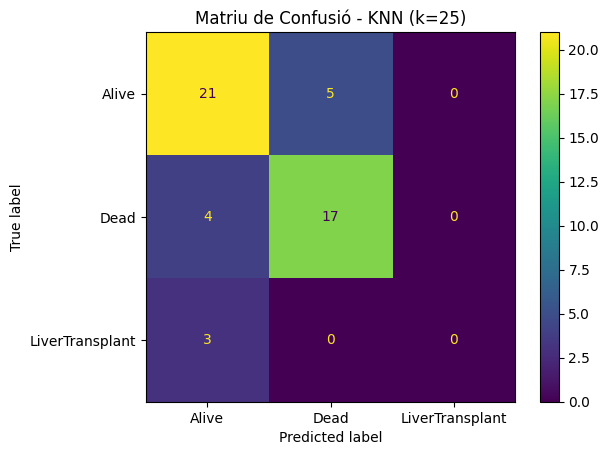

({'accuracy': 0.76,
  'f1-micro': 0.76,
  'f1-macro': 0.5228251507321274,
  'f1-weighted': 0.7365374677002583,
  'precision-micro': 0.76,
  'precision-macro': 0.5075757575757576,
  'precision-weighted': 0.7145454545454545,
  'recall-micro': 0.76,
  'recall-macro': 0.539072039072039,
  'recall-weighted': 0.76},
 25)

In [86]:
# Experiment amb millor dataset per a KNN
run_experiment(
	hide_all_messages=False,
	random_state=42,
	remove_outliers=False,
	outliers_factor=3,
	remove_last_rows=True,
	test_size=0.15,
	scaler='minmax',
	imputer_cross_val_folds=5,
	imputer_num_metric='r2',
	imputer_cat_metric='f1-weighted',
	encode=False,
	balancer='',
	predictor='knn',
	plot_correlations=False,
	execute_pca=False,
	knn_params={'k_list': [1, 2, 3, 5, 10, 15, 20, 25, 50], \
				'scorer_cross_val': 'f1-weighted', \
				'folds_cross_val': 5, \
				'plot_confusion_matrix': True, \
				'print_scores': True}		
)

**Experiment amb millor dataset per Decision Tree**

Train shape: (277, 19)
Test shape: (50, 19)
IMPUTER COMBINAT ESCOLLIT: IterativeImputer-lr (num) + RandomForestClassifier-gini (cat) --> 0.3580614108637571 (combinació de 'r2' i 'f1-weighted' en X_train)
IMPUTER COMBINAT ESCOLLIT: IterativeImputer-lr (num) + RandomForestClassifier-gini (cat) --> 0.3580614108637571 (combinació de 'r2' i 'f1-weighted' en X_train)
Mostres per classe abans de balancejar (oversample):
	*Alive: 147
	*Dead: 114
	*LiverTransplant: 16
	*Total de mostres: 277
Mostres per classe després de balancejar (oversample):
	*Alive: 147
	*LiverTransplant: 147
	*Dead: 147
	*Total de mostres: 441

MODEL DECISION TREE
Millors Paràmetres Cross Validation: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Millor Score Cross Validation (f1-weighted) --> 0.8318570902941925
SCORES BEST DECISION TREE ({'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2})
	*accuracy: 0.7
	*f1-micro: 0.7
	*f1-macro: 0.5724135182

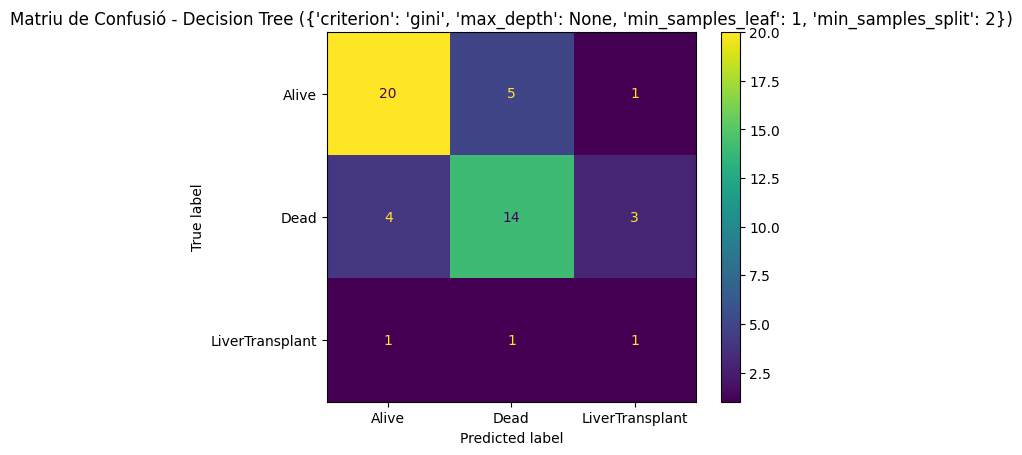

({'accuracy': 0.7,
  'f1-micro': 0.7,
  'f1-macro': 0.5724135182528296,
  'f1-weighted': 0.7096724055475849,
  'precision-micro': 0.7,
  'precision-macro': 0.5666666666666667,
  'precision-weighted': 0.722,
  'recall-micro': 0.7,
  'recall-macro': 0.5897435897435898,
  'recall-weighted': 0.7},
 {'criterion': 'gini',
  'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2})

In [87]:
# Experiment amb millor dataset per a DT
run_experiment(
	hide_all_messages=False,
	random_state=42,
	remove_outliers=False,
	outliers_factor=3,
	remove_last_rows=True,
	test_size=0.15,
	scaler='',
	imputer_cross_val_folds=5,
	imputer_num_metric='r2',
	imputer_cat_metric='f1-weighted',
	encode=True,
	balancer='oversample',
	predictor='dt',
	plot_correlations=False,
	execute_pca=False,
	dt_params={'criterion_list': ['entropy', 'gini'], \
				'max_depth_list': [None, 2, 3, 5, 10, 20, 50], \
				'min_samples_split_list': [2, 3, 5, 10, 20, 50], \
				'min_samples_leaf_list': [1, 2, 3, 5, 10, 20, 50], \
				'random_state': 42, \
				'folds_cross_val': 5, \
				'scorer_cross_val': 'f1-weighted', \
				'plot_confusion_matrix': True, \
				'print_scores': True}		
)

**Experiment amb millor dataset per SVM**

Train shape: (277, 19)
Test shape: (50, 19)
IMPUTER COMBINAT ESCOLLIT: KNNImputer-15 (num) + RandomForestClassifier-gini (cat) --> 0.3808342127551542 (combinació de 'r2' i 'f1-weighted' en X_train)
IMPUTER COMBINAT ESCOLLIT: KNNImputer-15 (num) + RandomForestClassifier-gini (cat) --> 0.3808342127551542 (combinació de 'r2' i 'f1-weighted' en X_train)
Mostres per classe abans de balancejar (smote):
	*Alive: 147
	*Dead: 114
	*LiverTransplant: 16
	*Total de mostres: 277
Mostres per classe després de balancejar (smote):
	*Alive: 147
	*LiverTransplant: 147
	*Dead: 147
	*Total de mostres: 441

MODEL SUPPORT VECTOR MACHINE (SVM)
Millors Paràmetres Cross Validation: {'C': 5, 'gamma': 'scale', 'kernel': 'linear'}
Millor Score Cross Validation (f1-weighted) --> 0.7462515571291796
SCORES BEST SVM ({'C': 5, 'gamma': 'scale', 'kernel': 'linear'})
	*accuracy: 0.8
	*f1-micro: 0.8000000000000002
	*f1-macro: 0.7362502681006221
	*f1-weighted: 0.8139203970953212
	*precision-micro: 0.8
	*precision-macro: 0

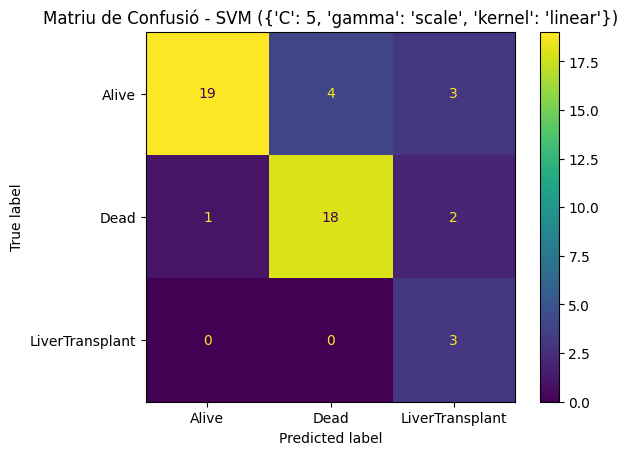

{'accuracy': 0.8,
 'f1-micro': 0.8000000000000002,
 'f1-macro': 0.7362502681006221,
 'f1-weighted': 0.8139203970953212,
 'precision-micro': 0.8,
 'precision-macro': 0.7143939393939394,
 'precision-weighted': 0.8601363636363637,
 'recall-micro': 0.8,
 'recall-macro': 0.8626373626373626,
 'recall-weighted': 0.8}

In [44]:
# Experiment amb millor dataset per a SVM
run_experiment(
	hide_all_messages=False,
	random_state=42,
	remove_outliers=False,
	outliers_factor=3,
	remove_last_rows=True,
	test_size=0.15,
	scaler='minmax',
	imputer_cross_val_folds=5,
	imputer_num_metric='r2',
	imputer_cat_metric='f1-weighted',
	encode=True,
	balancer='smote',
	predictor='svm',
	plot_correlations=False,
	execute_pca=False,
	svm_params={'kernel_list': ['linear', 'poly', 'rbf', 'sigmoid'], \
				'C_list': [0.1, 0.5, 1, 2, 3, 5], \
				'gamma_list': ['scale', 'auto'], \
				'scorer_cross_val': 'f1-weighted', \
				'folds_cross_val': 5, \
				'print_scores': True, \
				'plot_confusion_matrix': True, \
				'random_state': 42}
)

**Experiment amb el millor model SVM (millor datset i millors hiperparàmetres)**

In [54]:
n_executions = 5
used_seeds = [29, 34, 85, 32, 5]
scores = []
for i in range(n_executions):
	seed = used_seeds[i]
	tmp_scores = run_experiment(
		hide_all_messages=True,
		random_state=seed,
		remove_outliers=False,
		outliers_factor=3,
		remove_last_rows=True,
		test_size=0.15,
		scaler='minmax',
		imputer_cross_val_folds=5,
		imputer_num_metric='r2',
		imputer_cat_metric='f1-weighted',
		imputer_num='KNNImputer-15',
		imputer_cat='RandomForestClassifier-gini',
		encode=True,
		balancer='smote',
		predictor='svm',
		plot_correlations=False,
		execute_pca=False,
		svm_params={'kernel_list': ['linear'], \
					'C_list': [1], \
					'gamma_list': ['scale'], \
					'scorer_cross_val': 'f1-weighted', \
					'folds_cross_val': 5, \
					'print_scores': False, \
					'plot_confusion_matrix': False, \
					'random_state': 42}
	)

	scores.append(tmp_scores['f1-weighted'])

print(f"F1-Score-Weighted mitjà en {n_executions} execucions: {np.mean(scores)}\nLlavors utilitzades: {used_seeds}")

F1-Score-Weighted mitjà en 5 execucions: 0.639790436786899
Llavors utilitzades: [29, 34, 85, 32, 5]


### **BONUS 2: Anàlisi No Supervisat**